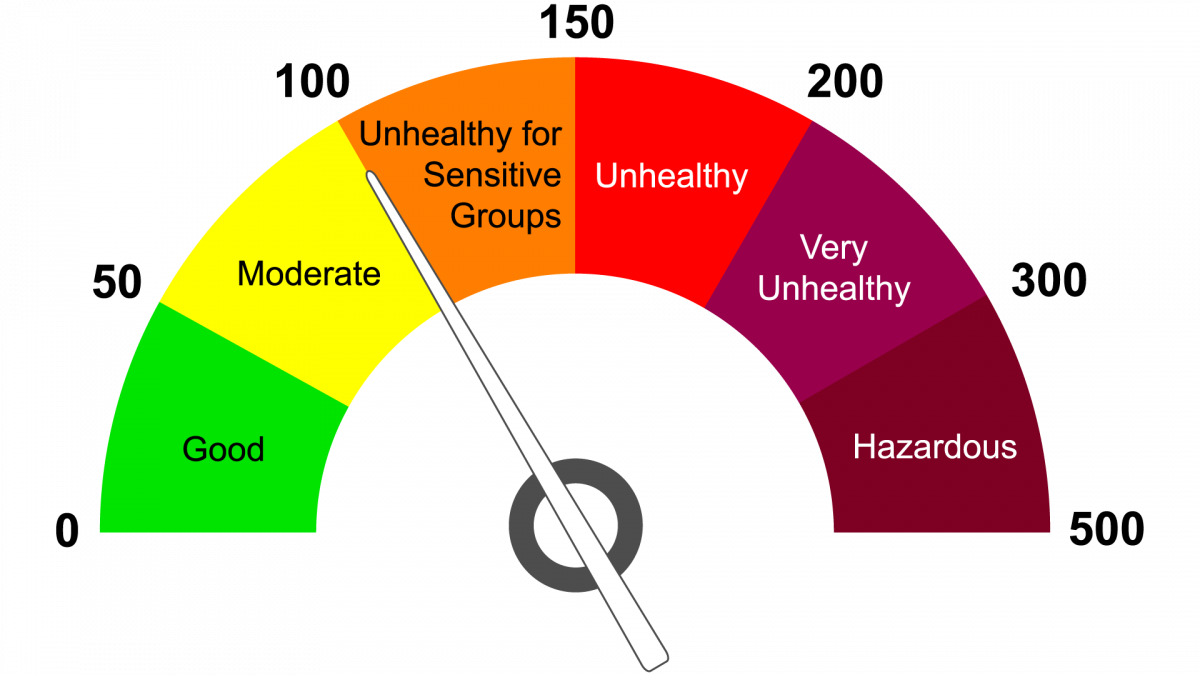

# Air quality data of Delhi
In this notebook we are going to observe the trend of different pollutant over the year in Delhi. Majorly we are going to focus on PM2.5 concentration. 

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from prophet import Prophet
import random
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
random.seed(1234)

In [2]:
data=pd.read_csv('/kaggle/input/delhi-air-quality/delhi_aqi.csv')

In [3]:
data.head()

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2020-11-25 01:00:00,2616.88,2.18,70.60,13.59,38.62,364.61,411.73,28.63
1,2020-11-25 02:00:00,3631.59,23.25,89.11,0.33,54.36,420.96,486.21,41.04
2,2020-11-25 03:00:00,4539.49,52.75,100.08,1.11,68.67,463.68,541.95,49.14
3,2020-11-25 04:00:00,4539.49,50.96,111.04,6.44,78.20,454.81,534.00,48.13
4,2020-11-25 05:00:00,4379.27,42.92,117.90,17.17,87.74,448.14,529.19,46.61


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18776 entries, 0 to 18775
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    18776 non-null  object 
 1   co      18776 non-null  float64
 2   no      18776 non-null  float64
 3   no2     18776 non-null  float64
 4   o3      18776 non-null  float64
 5   so2     18776 non-null  float64
 6   pm2_5   18776 non-null  float64
 7   pm10    18776 non-null  float64
 8   nh3     18776 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [5]:
data['date']=pd.to_datetime(data['date'])

In [6]:
data_new=data.set_index('date')

In [7]:
data_new

,co,no,no2,o3,so2,pm2_5,pm10,nh3
date,,,,,,,,
2020-11-25 01:00:00,2616.88,2.18,70.60,13.59,38.62,364.61,411.73,28.63
2020-11-25 02:00:00,3631.59,23.25,89.11,0.33,54.36,420.96,486.21,41.04
2020-11-25 03:00:00,4539.49,52.75,100.08,1.11,68.67,463.68,541.95,49.14
2020-11-25 04:00:00,4539.49,50.96,111.04,6.44,78.20,454.81,534.00,48.13
2020-11-25 05:00:00,4379.27,42.92,117.90,17.17,87.74,448.14,529.19,46.61
...,...,...,...,...,...,...,...,...
2023-01-24 04:00:00,1762.39,4.64,37.01,33.26,30.52,231.15,289.84,6.27
2023-01-24 05:00:00,1735.69,6.82,34.96,46.49,34.33,225.08,280.52,9.12
2023-01-24 06:00:00,1922.61,8.16,40.10,56.51,43.39,242.49,296.07,12.54


# EDA

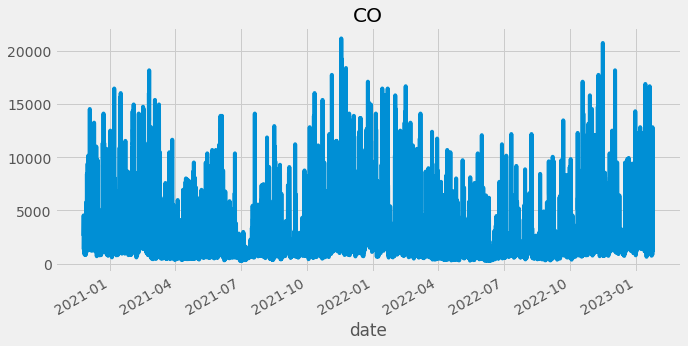

In [8]:
plt.figure(figsize=(15,10))
color_pal=sns.color_palette()
data_new['co'].plot(style='-',figsize=(10,5),
                     ms=1,
                     color=color_pal[0],
                     title='CO')
plt.show()

In [9]:
from pandas.api.types import CategoricalDtype

cat_type= CategoricalDtype(categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    
    df= df.copy()
    df['date']=df.index
    df['hour']=df['date'].dt.hour
    df['dayofweek']=df['date'].dt.dayofweek
    df['weekday']=df['date'].dt.day_name()
    df['weekday']=df['weekday'].astype(cat_type)
    df['quarter']=df['date'].dt.quarter
    df['month']=df['date'].dt.month
    df['year']=df['date'].dt.year
    df['dayofyear']=df['date'].dt.dayofyear
    df['dayofmonth']=df['date'].dt.day
    df['weekofyear']=df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100+df.date.dt.day -320)%1300
    
    X=df[['hour','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear','weekday']]
    return X

X= create_features(data_new)
all_data= pd.concat([X,data_new],axis=1)

In [10]:
all_data.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,co,no,no2,o3,so2,pm2_5,pm10,nh3
date,,,,,,,,,,,,,,,,,
2020-11-25 01:00:00,1,2,4,11,2020,330,25,48,Wednesday,2616.88,2.18,70.60,13.59,38.62,364.61,411.73,28.63
2020-11-25 02:00:00,2,2,4,11,2020,330,25,48,Wednesday,3631.59,23.25,89.11,0.33,54.36,420.96,486.21,41.04
2020-11-25 03:00:00,3,2,4,11,2020,330,25,48,Wednesday,4539.49,52.75,100.08,1.11,68.67,463.68,541.95,49.14
2020-11-25 04:00:00,4,2,4,11,2020,330,25,48,Wednesday,4539.49,50.96,111.04,6.44,78.20,454.81,534.00,48.13
2020-11-25 05:00:00,5,2,4,11,2020,330,25,48,Wednesday,4379.27,42.92,117.90,17.17,87.74,448.14,529.19,46.61


In [11]:
#adding seasons
season_month_north = {
            12:'Winter', 1:'Winter', 2:'Spring',
            3:'Spring', 4:'Summer', 5:'Summer',
            6:'Summer', 7:'Monsoon', 8:'Monsoon',
            9:'Autumn', 10:'Autumn', 11:'Autumn'}
all_data['seasons']=all_data['month'].map(season_month_north)

In [12]:
all_data.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,co,no,no2,o3,so2,pm2_5,pm10,nh3,seasons
date,,,,,,,,,,,,,,,,,,
2020-11-25 01:00:00,1,2,4,11,2020,330,25,48,Wednesday,2616.88,2.18,70.60,13.59,38.62,364.61,411.73,28.63,Autumn
2020-11-25 02:00:00,2,2,4,11,2020,330,25,48,Wednesday,3631.59,23.25,89.11,0.33,54.36,420.96,486.21,41.04,Autumn
2020-11-25 03:00:00,3,2,4,11,2020,330,25,48,Wednesday,4539.49,52.75,100.08,1.11,68.67,463.68,541.95,49.14,Autumn
2020-11-25 04:00:00,4,2,4,11,2020,330,25,48,Wednesday,4539.49,50.96,111.04,6.44,78.20,454.81,534.00,48.13,Autumn
2020-11-25 05:00:00,5,2,4,11,2020,330,25,48,Wednesday,4379.27,42.92,117.90,17.17,87.74,448.14,529.19,46.61,Autumn


In [13]:
#descriptive statistics
all_data[['co','no','no2','o3','so2','pm2_5','pm10','nh3']].describe()

,co,no,no2,o3,so2,pm2_5,pm10,nh3
count,18776.000000,18776.000000,18776.000000,18776.000000,18776.000000,18776.000000,18776.000000,18776.000000
mean,2929.228628,33.660702,66.221299,60.346239,66.693633,238.130309,300.092966,25.109815
std,2854.523506,62.127118,48.527492,80.464932,49.439191,226.533625,267.165827,26.402108
min,260.350000,0.000000,4.280000,0.000000,5.250000,11.830000,15.070000,0.000000
25%,1068.120000,0.680000,33.930000,0.340000,34.810000,84.440000,118.797500,9.630000
50%,1842.500000,5.250000,54.150000,27.180000,52.930000,157.445000,209.705000,17.480000
75%,3685.000000,35.760000,83.630000,92.980000,82.020000,313.000000,387.965000,30.400000
max,21148.680000,500.680000,460.620000,801.090000,579.830000,1708.090000,1969.930000,287.770000


## What is PM2.5?
Airborne particulate matter (PM) is not a single pollutant, but rather is a mixture of many chemical species. It is a complex mixture of solids and aerosols composed of small droplets of liquid, dry solid fragments, and solid cores with liquid coatings. Particles vary widely in size, shape and chemical composition, and may contain inorganic ions, metallic compounds, elemental carbon, organic compounds, and compounds from the earth’s crust. Particles are defined by their diameter for air quality regulatory purposes.

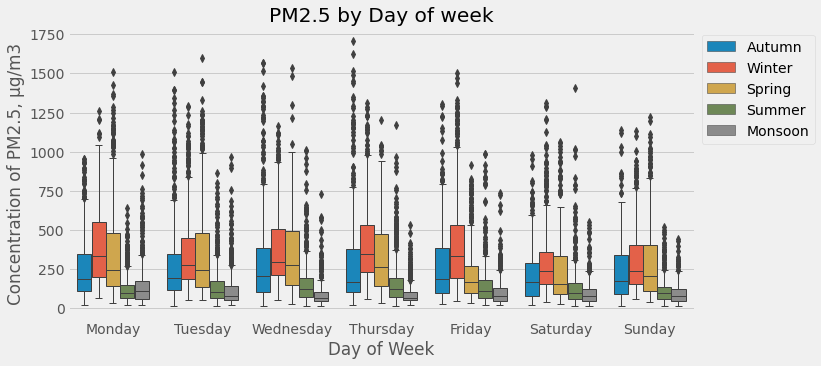

In [14]:
fig, ax= plt.subplots(figsize=(10,5))
sns.boxplot(data=all_data.dropna(),
           x='weekday',
           y='pm2_5',
           hue='seasons',
           ax=ax,
           linewidth=1)
ax.set_title('PM2.5 by Day of week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Сoncentration of PM2.5, μg/m3')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

## Observations
* Winter and Spring have the highest PM2.5 which is quite expected.
* Monsoon season have the least PM2.5
* Weekends have less PM2.5

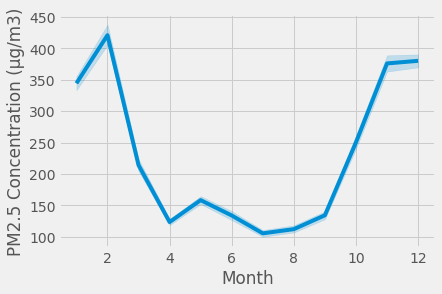

In [15]:
# Monthly PM 2.5 concentation trend 
sns.lineplot(x='month', y='pm2_5', data=all_data)

# label the axes
plt.xlabel('Month')
plt.ylabel('PM2.5 Concentration (µg/m3)')

# show the graph
plt.show()

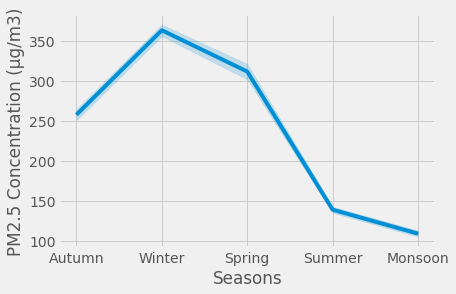

In [16]:
# Seasonly PM 2.5 Concentration trend
sns.lineplot(x='seasons', y='pm2_5', data=all_data)

# label the axes
plt.xlabel('Seasons')
plt.ylabel('PM2.5 Concentration (µg/m3)')

# show the graph
plt.show()

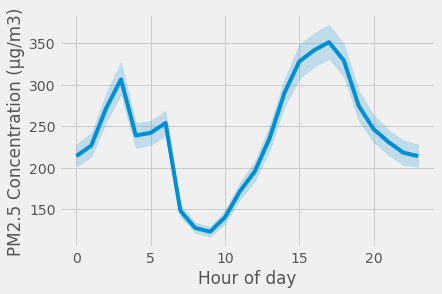

In [17]:
# Hourly PM 2.5 Concentration trend
sns.lineplot(x='hour', y='pm2_5', data=all_data)

# label the axes
plt.xlabel('Hour of day')
plt.ylabel('PM2.5 Concentration (µg/m3)')

# show the graph
plt.show()

In [18]:
def avg_pm_plot(x):    
    average_pm2_5_seasons=all_data.groupby(x).mean()['pm2_5']
    sns.barplot(x=average_pm2_5_seasons.index,y=average_pm2_5_seasons.values)
    # label the axes
    plt.xlabel(x)
    plt.ylabel('PM2.5 Concentration (µg/m3)')

    # show the graph
    plt.show()

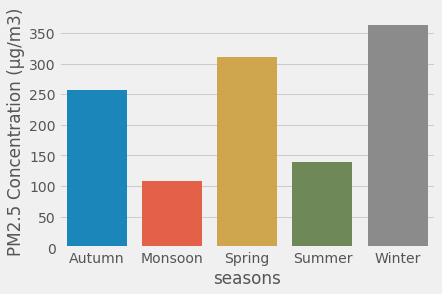

In [19]:
#average pm2.5 concentration around the seasons
avg_pm_plot('seasons')

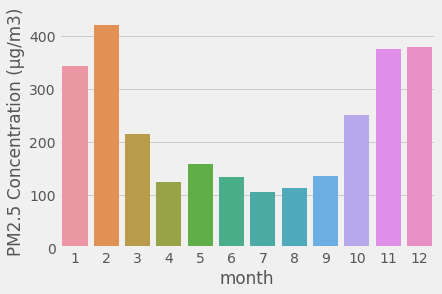

In [20]:
#average pm2.5 concentration around the month
avg_pm_plot('month')

<AxesSubplot:>

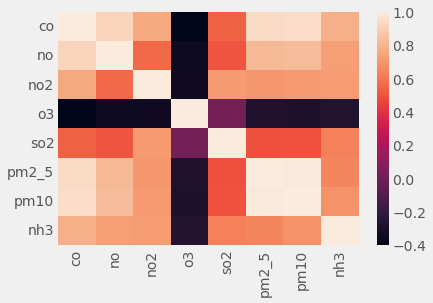

In [21]:
#correlation between all metrics
sns.heatmap(all_data[['co','no','no2','o3','so2','pm2_5','pm10','nh3']].corr())

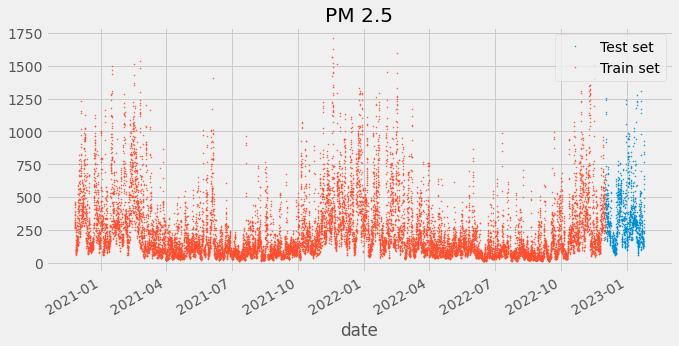

In [22]:
#spliting data
split_date='2022-12-01'
pm_train=all_data.loc[all_data.index<=split_date].copy()
pm_train=pd.DataFrame(pm_train['pm2_5'])
pm_test=all_data.loc[all_data.index>split_date].copy()
pm_test=pd.DataFrame(pm_test['pm2_5'])

#plotting train and test
pm_test.rename(columns={'pm2_5':'Test set'})\
                .join(pm_train.rename(columns={'pm2_5':'Train set'}), how='outer')\
                .plot(figsize=(10,5), title='PM 2.5', style=".", ms=1)
plt.show()

In [23]:
pm_train=pm_train.reset_index().rename(columns={'date':'ds','pm2_5':'y'})
pm_train.head()

,ds,y
0,2020-11-25 01:00:00,364.61
1,2020-11-25 02:00:00,420.96
2,2020-11-25 03:00:00,463.68
3,2020-11-25 04:00:00,454.81
4,2020-11-25 05:00:00,448.14


# Model fitting and forecasting

In [24]:
m=Prophet()
m.fit(pm_train)

17:48:04 - cmdstanpy - INFO - Chain [1] start processing
17:48:11 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
pm_test=pm_test.reset_index().rename(columns={'date':'ds','pm2_5':'y'})

In [26]:
pm_test_fcst=m.predict(pm_test)

In [27]:
pm_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-12-01 01:00:00,166.378649,166.759820,626.684582,166.378649,166.378649,226.589284,226.589284,226.589284,3.093590,...,27.995761,27.995761,27.995761,195.499933,195.499933,195.499933,0.0,0.0,0.0,392.967933
1,2022-12-01 02:00:00,166.361429,200.798228,632.676902,166.361429,166.361429,248.538282,248.538282,248.538282,25.254742,...,27.747181,27.747181,27.747181,195.536358,195.536358,195.536358,0.0,0.0,0.0,414.899711
2,2022-12-01 03:00:00,166.344209,199.246583,657.116012,166.344209,166.344209,265.072375,265.072375,265.072375,42.033166,...,27.466446,27.466446,27.466446,195.572763,195.572763,195.572763,0.0,0.0,0.0,431.416585
3,2022-12-01 04:00:00,166.326989,199.702573,658.819596,166.326989,166.326989,263.793269,263.793269,263.793269,41.031207,...,27.152919,27.152919,27.152919,195.609143,195.609143,195.609143,0.0,0.0,0.0,430.120258
4,2022-12-01 05:00:00,166.309769,199.488818,630.710883,166.309769,166.309769,238.542475,238.542475,238.542475,16.091132,...,26.805848,26.805848,26.805848,195.645495,195.645495,195.645495,0.0,0.0,0.0,404.852244


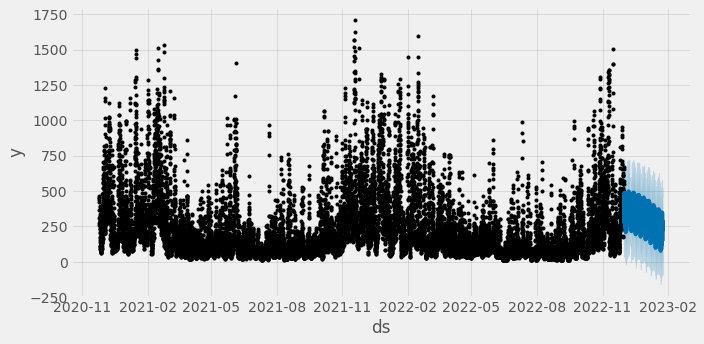

In [28]:
fig,ax= plt.subplots(figsize=(10,5))
fig= m.plot(pm_test_fcst,ax=ax)
plt.show()

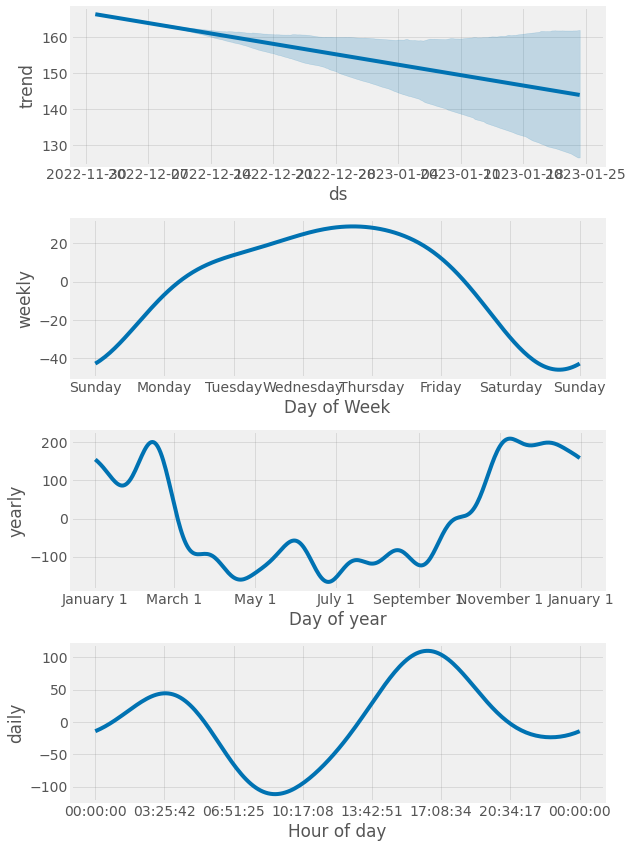

In [29]:
fig= m.plot_components(pm_test_fcst)
plt.show()

# Comparing forecast with the original

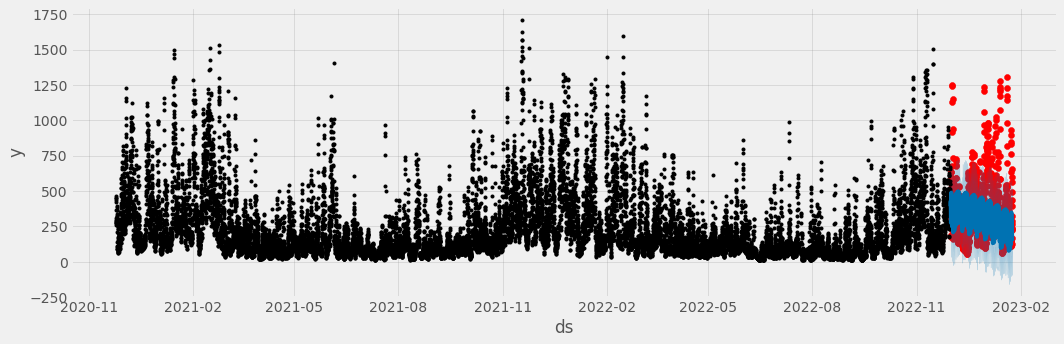

In [30]:
f,ax= plt.subplots(figsize=(15,5))
ax.scatter(pm_test['ds'], pm_test['y'],color='r')
fig=m.plot(pm_test_fcst,ax=ax)

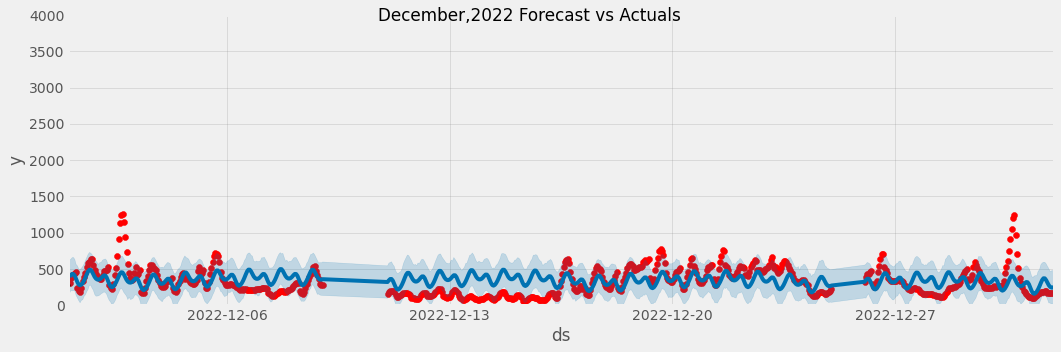

In [31]:
#checking for the first month
f,ax= plt.subplots(figsize=(15,5))
ax.scatter(pm_test['ds'], pm_test['y'],color='r')
f=m.plot(pm_test_fcst,ax=ax)
ax.set_xbound(lower='2022-12-01',
             upper='2023-01-01')
ax.set_ylim(0,4000)
plot=plt.suptitle('December,2022 Forecast vs Actuals')